In [ ]:
import numpy as np
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
from google.colab import drive

In [ ]:
#V1
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:

#drive.mount('/content/drive/')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/GarbageDatasets/garbage_classification_del.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

base_path = "../tmp/garbage_classification_del/"
print('Done')


Done


In [ ]:
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes','e-waste', 'green-glass','light-bulbs', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [ ]:
filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + category)
    
    filenames_list += filenames
    categories_list += [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

df.head(20)


,filename,category
0,trash/trash395.jpg,trash
1,clothes/clothes5027.jpg,clothes
2,metal/metal1077.jpg,metal
3,biological/biological1374.jpg,biological
4,cardboard/cardboard582.jpg,cardboard
5,clothes/clothes1899.jpg,clothes
6,biological/biological1029.jpg,biological
7,trash/trash441.jpg,trash
8,biological/biological1160.jpg,biological
9,trash/trash258.jpg,trash


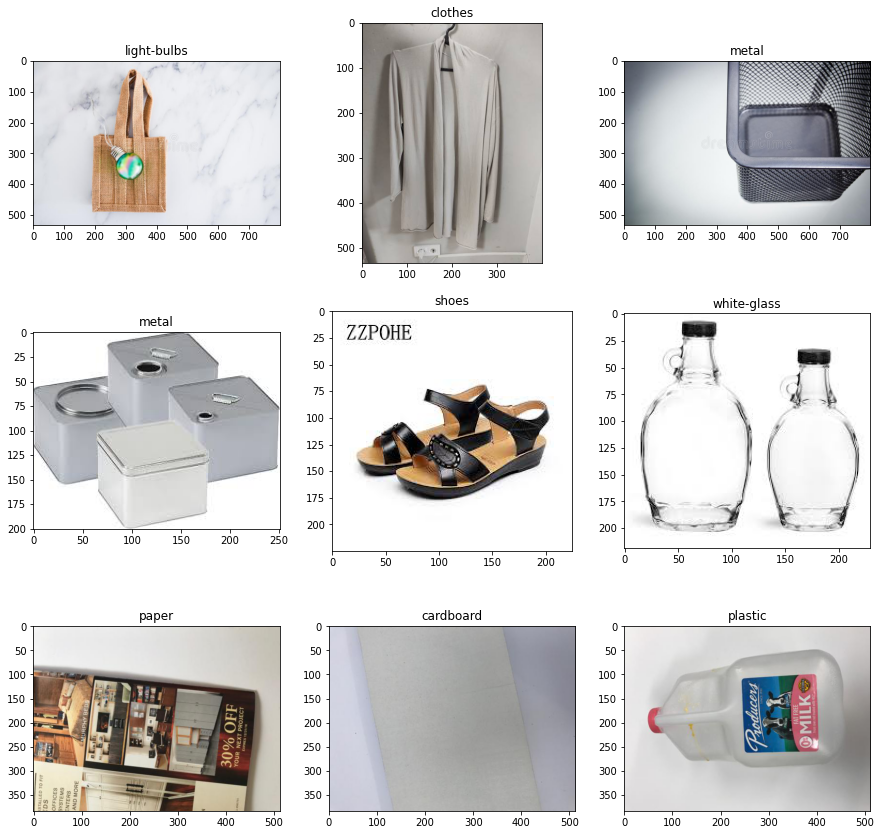

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = image.load_img(base_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

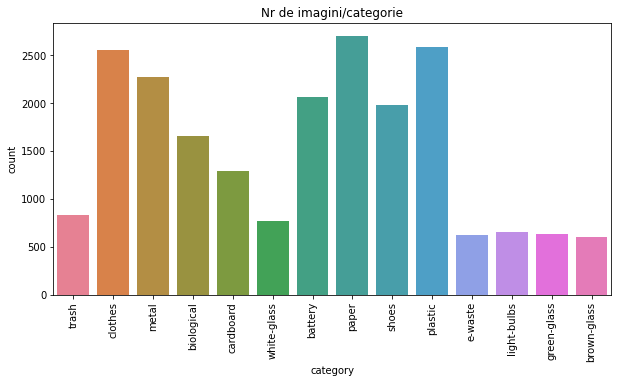

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='husl')
plt.xticks(rotation=90)
plt.title('Nr de imagini/categorie')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.5, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.1, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(10615, 9554, 1062)

In [ ]:
train_df.head()

,filename,category
0,paper/paper1334.jpg,paper
1,biological/biological578.jpg,biological
2,plastic/plastic1013.jpg,plastic
3,e-waste/e-waste456.jpg,e-waste
4,battery/battery1840.jpg,battery


In [ ]:
#Simple CNN¶
  
im_shape = (224, 224)
batch_size = 64
seed = 42
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

print("train")
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

print("val")
val_generator = val_data_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

print('test')
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

train
Found 10615 validated image filenames belonging to 14 classes.
val
Found 9554 validated image filenames belonging to 14 classes.
test
Found 1062 validated image filenames belonging to 14 classes.


In [ ]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'e-waste', 'green-glass', 'light-bulbs', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [ ]:
input_shape = (224,224,3)
base_model = tf.keras.applications.Xception( include_top=False, weights = "imagenet", input_shape=input_shape)

# layers trainable pentru fine tunning
base_model.trainable = True
# review model
base_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
for layer in base_model.layers[:122]:
    layer.trainable =  False

for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [ ]:
# model = Sequential()

# model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(im_shape[0], im_shape[1], 3)))
# model.add(MaxPooling2D(pool_size=(2,2)))

# # model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
# # model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(BatchNormalization())

# model.add(Flatten())

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.4))

# # model.add(Dense(64, activation='relu'))
# # model.add(Dropout(0.4))

# model.add(Dense(num_classes, activation='softmax'))

# model.summary()

# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(learning_rate=0.0001),
#               metrics=['accuracy'])

In [ ]:
model = tf.keras.Sequential([
    #data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(14, activation='softmax')
])

learning_rate = 0.001
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                7182      
                                                                 
Total params: 21,917,750
Trainable params: 6,552,590
Non-trainable params: 15,365,160
____________________________________

In [ ]:
%%time
epochs = 20

#Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='/tmp/model.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
165/165 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.7899
Epoch 00001: val_loss improved from inf to 0.56883, saving model to /tmp/model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


165/165 [==============================] - 122s 660ms/step - loss: 0.6972 - accuracy: 0.7899 - val_loss: 0.5688 - val_accuracy: 0.8313
Epoch 2/20
165/165 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.9099
Epoch 00002: val_loss improved from 0.56883 to 0.41530, saving model to /tmp/model.h5
165/165 [==============================] - 109s 661ms/step - loss: 0.2891 - accuracy: 0.9099 - val_loss: 0.4153 - val_accuracy: 0.8851
Epoch 3/20
165/165 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9447
Epoch 00003: val_loss did not improve from 0.41530
165/165 [==============================] - 109s 659ms/step - loss: 0.1720 - accuracy: 0.9447 - val_loss: 0.5061 - val_accuracy: 0.8717
Epoch 4/20
165/165 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9587
Epoch 00004: val_loss did not improve from 0.41530
165/165 [==============================] - 108s 656ms/step - loss: 0.1268 - accuracy: 0.9587 - val_loss: 0.5981 - val_a

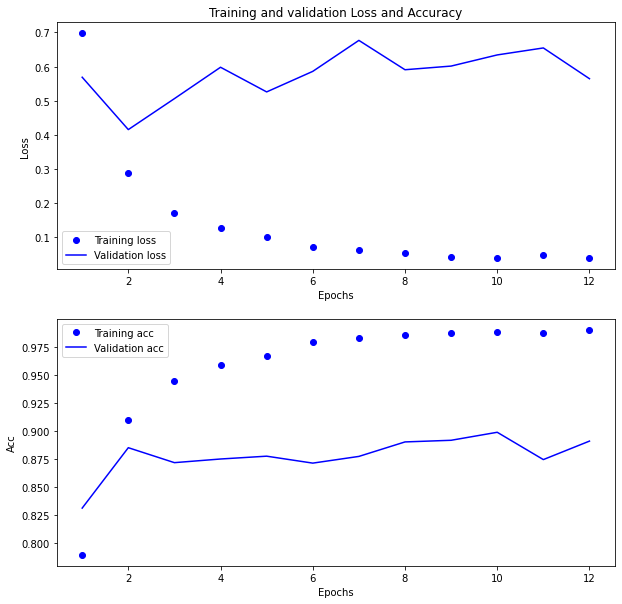

In [ ]:
# Training curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
# model = load_model('../input/keras-simple-cnn-gargabe-classification/model.h5')
model = load_model('/tmp/model.h5')
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

150/150 [==============================] - 52s 340ms/step - loss: 0.4155 - accuracy: 0.8851
Val loss: 0.41550445556640625
Val accuracy: 0.8850743174552917


In [ ]:

model.save('model.h5')

In [ ]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1062/1062 [==============================] - 16s 15ms/step - loss: 0.3963 - accuracy: 0.8955
Test loss: 0.3962600529193878
Test accuracy: 0.895480215549469


Classification Report
              precision    recall  f1-score   support

     battery       0.94      0.80      0.86       119
  biological       0.94      0.97      0.96        88
 brown-glass       0.96      0.85      0.90        27
   cardboard       0.71      0.93      0.81        54
     clothes       0.98      0.90      0.94       124
     e-waste       0.86      0.86      0.86        22
 green-glass       0.92      0.85      0.88        27
 light-bulbs       0.96      0.93      0.94        27
       metal       0.81      0.94      0.87       101
       paper       0.88      0.91      0.89       159
     plastic       0.83      0.86      0.84       127
       shoes       0.95      0.98      0.97       108
       trash       1.00      0.82      0.90        40
 white-glass       0.94      0.85      0.89        39

    accuracy                           0.90      1062
   macro avg       0.91      0.89      0.89      1062
weighted avg       0.90      0.90      0.90      1062



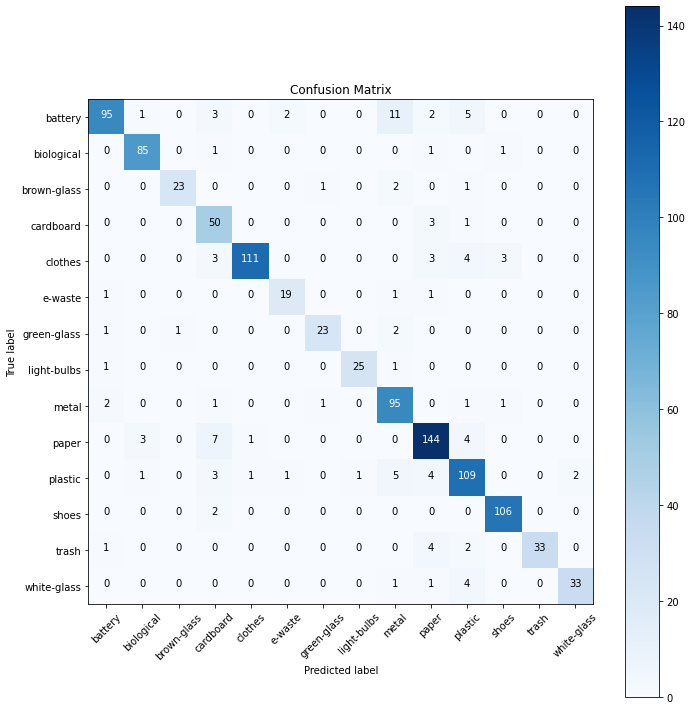

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
from tensorflow.keras.preprocessing import image
output_class = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal',
                'paper', 'plastic', 'shoes', 'trash', 'white-glass']
def waste_prediction(new_image):
  test_image = image.load_img(new_image, target_size = (256,256))
  plt.axis("off")
  plt.imshow(test_image)
  plt.show()
 
  test_image = image.img_to_array(test_image) / 255
  test_image = np.expand_dims(test_image, axis=0)

  predicted_array = model.predict(test_image)
  predicted_value = output_class[np.argmax(predicted_array)]
  predicted_accuracy = round(np.max(predicted_array) * 100, 2)

  print("Your waste material is ", predicted_value, " with ", predicted_accuracy, " % accuracy")

In [ ]:
waste_prediction("../tmp/bere.jpg")